<div style="background-color:#5D73F2; color:#19180F; font-size:40px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px"> Siamese Networks </div>
<div style="background-color:#A8B4F6; color:#19180F; font-size:30px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px"> Architecture Overview</div>
<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px"> Siamese networks are shown in block diagram below and their description is as follows.<br><br>
<b>1. Input nodes</b> The Input 1 and Input 2 input nodes are the Siamese network's input nodes. These inputs serve as the two samples that the network will compare.<br><br>
<b>2. The Siamese Model</b>: It is the primary element of the network. Each of the two input branches shares a number of its layers. The network can pick up common features from the inputs thanks to this shared architecture.<br><br>
<b>3. Convolutional Layers:</b> The Siamese Model starts with four Convolutional layers (Conv2D) that have ReLU activation and four different filter sizes (16, 32, 64, and 128). These layers take the input images' features and extract them.<br><br>
<b>4. Pooling Layers:</b> A Max Pooling layer (MaxPooling2D) with a 2x2 kernel is applied after every Convolutional layer. These layers shrink the spatial dimensions of the feature maps by downsampling them.<br><br>
<b>5.Dropout Layers:</b> Following each Max Pooling layer are Dropout layers (Dropout) with a rate of 0.25. By randomly disabling a portion of the neurons during training, dropout aids in the prevention of overfitting.<br><br>
<b>6.Flatten Layer</b> The output of the final Dropout layer is flattened into a 1-dimensional vector to make it ready for the upcoming fully connected layers.<br><br>
<b>7. </b>Dense Layers</b>: ReLU activation is used along with two dense layers that are fully connected and have 512 and 128 units, respectively.These layers modify the features that were extracted from the Convolutional layers further.<br><br>
<b>8.Lambda Layer</b>Tensors[0] and Tensors[1] are the outputs of the two lambda layer (Lambda) branches. It computes the absolute difference between the inputs (abs(tensors[0] - tensors[1]). This technique determines the distinctions between the two input samples.<br><br>
<b>9. Final Layer:</b> The output of the Lambda layer is fed into the Dense layer (Dense) using a single unit and sigmoid activation.This layer computes a probability score that reflects how similar the two input samples are, with higher values suggesting greater similarity and lower values indicating greater dissimilarity.<br><br>
The diagram depicts the path that data takes as it goes from input nodes through shared layers and then to the final destination. To make it clear that tensors[0] and tensors[1] represent the outputs of the shared layers in the Siamese Model, the additional nodes embedding1 and embedding2 and their connections to the Lambda layer are included. The Lambda layer uses these outputs to compute the dissimilarity between the two input samples by using the learned features or embeddings for the two input samples.</div>

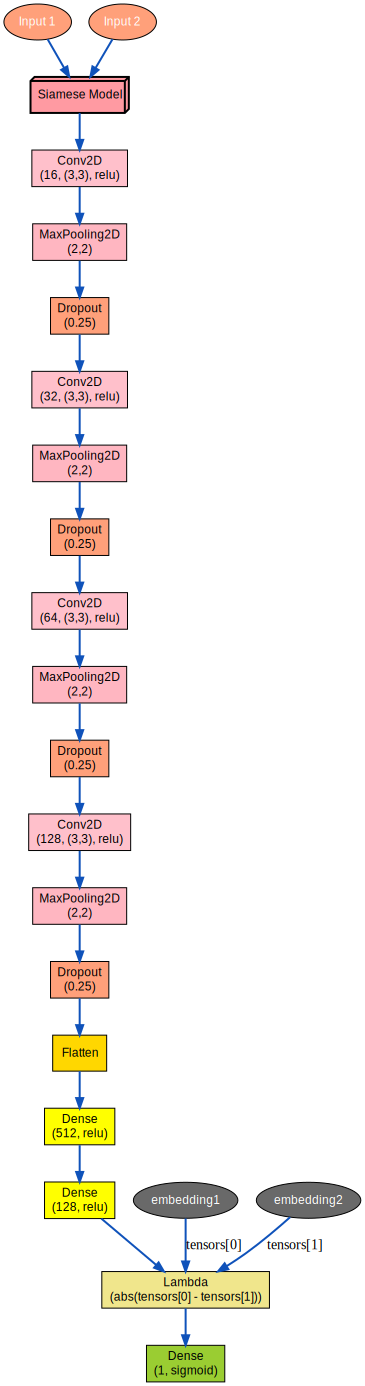

In [1]:
from IPython.display import SVG, display

# Load the SVG file and display it
svg_file = '/kaggle/input/machine-learning-architecture-diagrams/SiameseNetworks.svg'
display(SVG(filename=svg_file))

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Importing modules
    </div>


In [2]:
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, Dropout, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
import pandas as pd
from PIL import Image
import urllib
import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Reading the datasets</div>


In [3]:
train_dataset = pd.read_csv('/kaggle/input/signature-verification-dataset/sign_data/train_data.csv')
test_dataset = pd.read_csv('/kaggle/input/signature-verification-dataset/sign_data/train_data.csv')

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Defining the train and test directory path    </div>


In [4]:
train_dir = "/kaggle/input/signature-verification-dataset/sign_data/train"
test_dir = "/kaggle/input/signature-verification-dataset/sign_data/test"

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Defining data loader class    </div>


In [5]:
class DataLoader:
  #constructor
  def __init__(self, dataset, batch_size,dir):
    self.dataset = dataset
    self.batch_size = batch_size
    self.dir = dir
  #shuffler
  def shuffle(self):
    return self.dataset.sample(frac=1)
  #generator
  def datagen(self):
    num_samples = len(self.dataset)
    while True:
        # shuffling the samples
        self.dataset = self.shuffle()
        for batch in range(1, num_samples, self.batch_size):
            image1_batch_samples = self.dir + "/" + self.dataset.iloc[:, 0][batch:batch + self.batch_size]
            image2_batch_samples = self.dir + "/" + self.dataset.iloc[:, 1][batch:batch + self.batch_size]
            label_batch_samples = self.dataset.iloc[:, 2][batch:batch + self.batch_size]
            Image1, Image2, Label = [], [], []
            for image1, image2, label in zip(image1_batch_samples, image2_batch_samples, label_batch_samples):
                # append them to Images directly
                image1_data = Image.open(image1)
                image2_data = Image.open(image2)
                # resizing the images
                image1_data = image1_data.resize((112, 112))
                image2_data = image2_data.resize((112, 112))
                # converting to array
                image1_data = img_to_array(image1_data)
                image2_data = img_to_array(image2_data)
                Image1.append(image1_data)
                Image2.append(image2_data)
                Label.append(label)
            # convert each list to numpy arrays to ensure that they get processed by fit function
            Image1 = np.asarray(Image1).astype(np.float32)
            Image2 = np.asarray(Image2).astype(np.float32)
            Label = np.asarray(Label).astype(np.float32)
            yield [Image1, Image2], Label


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Splitting the data into train & val set    </div>


In [6]:
train_set, val_set = train_test_split(train_dataset, test_size=0.25)


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
creating dataloaders</div>


In [7]:
train_gen= DataLoader(train_set,1024,train_dir)
val_gen = DataLoader(val_set,1024,train_dir)

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Performing sanity check of the dataloader    </div>


In [8]:
train_batch = next(train_gen.datagen())
print("Train batch images shape:", train_batch[0][0].shape, train_batch[0][1].shape)
print("Train batch labels shape:", train_batch[1].shape)


Train batch images shape: (6, 112, 112, 3) (6, 112, 112, 3)
Train batch labels shape: (6,)


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Defining custom siamese model architecture    </div>


In [9]:
def custom_siamese_model(input_shape):
    input1 = Input(input_shape)
    input2 = Input(input_shape)
    
    model = Sequential()
    model.add(Conv2D(16, (3,3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))

    # Call the model with the inputs
    embedding1 = model(input1)
    embedding2 = model(input2)

    loss_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
    manhattan_distance = loss_layer([embedding1, embedding2])
    output = Dense(1, activation='sigmoid')(manhattan_distance)
    network = Model(inputs=[input1, input2], outputs=output)
    return network

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Instantiating early stopper with custom callbacks    </div>


In [10]:
early_stopper =  EarlyStopping(monitor='val_loss',min_delta=0,patience=3,verbose=1)
custom_callback = [early_stopper]

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Instantiating model    </div>


In [11]:
model = custom_siamese_model((112,112,3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 112, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128)          1802016     ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Defining the model and compiling it</div>


In [12]:
optimizer = Adam(lr = 1e-4)
model.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy'])


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Training the model for 2 epochs    </div>


In [13]:
print("Initializing Training !!")
history = model.fit_generator(
    train_gen.datagen(),
    verbose=1,
    steps_per_epoch=100,  # set appropriate steps_per_epoch
    epochs=5,
    validation_data=val_gen.datagen(),
    validation_steps=100,  # set appropriate validation_steps
    callbacks=custom_callback
)


Initializing Training !!
Epoch 1/5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == "__main__":
2023-07-10 10:30:48.792612: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


100/100 [==============================] - 11s 59ms/step - loss: 0.0140 - accuracy: 0.9983 - val_loss: 1.1757e-17 - val_accuracy: 1.0000
Epoch 2/5
100/100 [==============================] - 7s 72ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 2.7213e-18 - val_accuracy: 1.0000
Epoch 3/5
100/100 [==============================] - 7s 67ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 2.4103e-18 - val_accuracy: 1.0000
Epoch 4/5
100/100 [==============================] - 5s 54ms/step - loss: 2.0164e-33 - accuracy: 1.0000 - val_loss: 2.6047e-18 - val_accuracy: 1.0000
Epoch 5/5
100/100 [==============================] - 5s 55ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 2.6047e-18 - val_accuracy: 1.0000


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Plotting the accuracy and loss plots    </div>


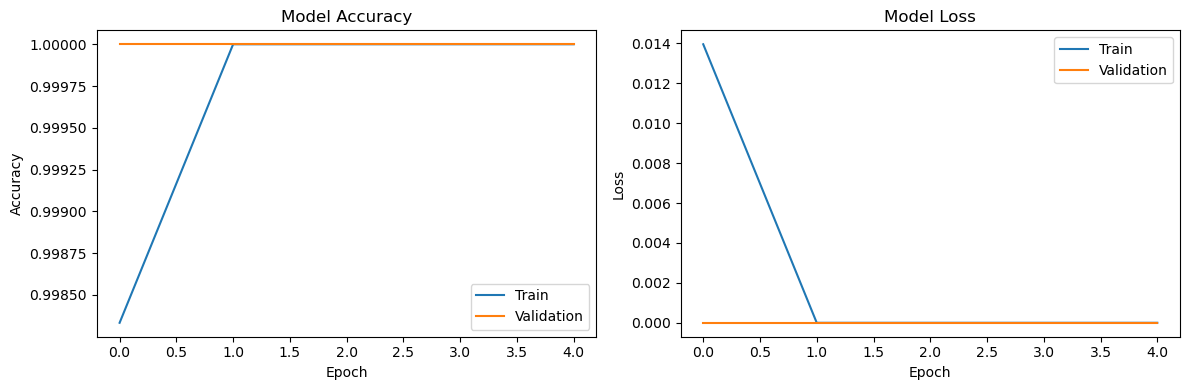

In [14]:
history_keys = history.history.keys()

plt.figure(figsize=(12, 4))

# Plot the accuracy curves
if 'accuracy' in history_keys and 'val_accuracy' in history_keys:
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

# Plot the loss curves
if 'loss' in history_keys and 'val_loss' in history_keys:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Inferencing the trained model on original and forged images    </div>


1/1 [==============================] - 0s 218ms/step
Similarity Score: 1.0


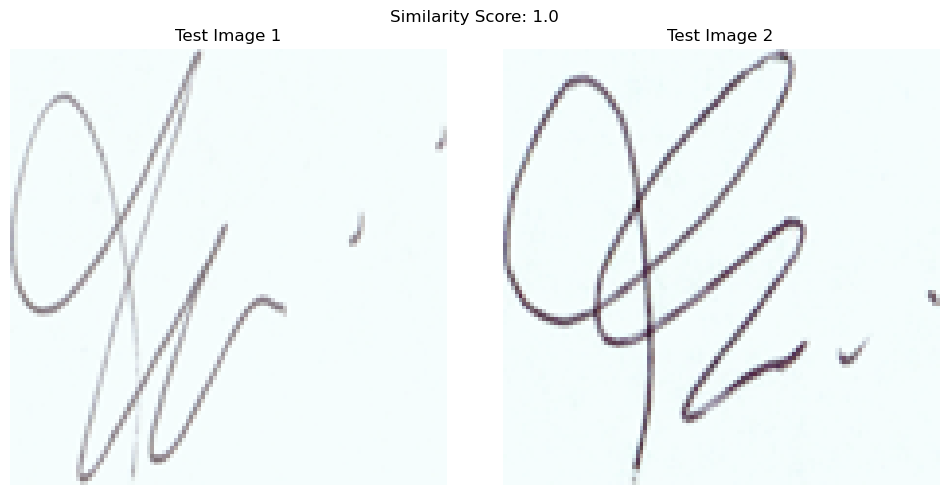

In [15]:
# Define the paths to the test images
test_image1_path = '/kaggle/input/signature-verification-dataset/sign_data/test/049/01_049.png'
test_image2_path = '/kaggle/input/signature-verification-dataset/sign_data/test/049_forg/01_0114049.PNG'

# Load and preprocess the test images
test_image1 = Image.open(test_image1_path)
test_image1 = test_image1.resize((112, 112))
test_image1 = img_to_array(test_image1)
test_image1 = np.expand_dims(test_image1, axis=0)
test_image1 = test_image1.astype('float32')

test_image2 = Image.open(test_image2_path)
test_image2 = test_image2.resize((112, 112))
test_image2 = img_to_array(test_image2)
test_image2 = np.expand_dims(test_image2, axis=0)
test_image2 = test_image2.astype('float32')

# Perform inference on the test images
prediction = model.predict([test_image1, test_image2])

# Print the similarity score
similarity_score = prediction[0][0]
print('Similarity Score:', similarity_score)

# Display the test images with the similarity score as legend
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image1[0].astype('uint8'))
plt.title('Test Image 1')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(test_image2[0].astype('uint8'))
plt.title('Test Image 2')
plt.axis('off')

plt.suptitle(f'Similarity Score: {similarity_score}', fontsize=12)
plt.tight_layout()
plt.show()

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    <b> End Remarks</b><br>
Quite Decent Accuracy on Test Set !</div>
